# Modern Portfolio Theory (MPT)

Modern Portfolio Theory (MPT), developed by economist Harry Markowitz in the 1950s, is a framework for constructing investment portfolios that aim to maximize expected returns for a given level of risk or minimize the level of risk for a given expected return. 
MPT revolutionized the way investors think about diversification and risk management. 
Modern Portfolio Theory has had a profound impact on investment strategy and asset allocation, providing a systematic approach to balancing risk and return in investment portfolios. 

In this notebook we will be implementing the portfolio optimization from scratch and then use some packages to automate it. Later we will also look at different volatility calculations and how it affects the results.

## Equally-weighted portfolio

In [1]:
import yfinance as yf
import pandas_datareader.data as pdr
import seaborn as sns 
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
import quantstats as qs

yf.pdr_override()

# Define a list of stock symbols belonging to tech sectors

stock_symbols = ["META", "TSLA", "X", "MSFT"]

# start date
start_date = '2018-01-01'
# end date
end_date = '2023-01-01'

# Fetch stock data along with sector information
prices_df = pdr.get_data_yahoo(stock_symbols,start_date,end_date)['Adj Close']


# assign equal weights to all assets
weights = np.array(len(stock_symbols) * [1 / len(stock_symbols)])


# returns
returns = prices_df.pct_change()
returns.dropna(inplace=True)


# portfolio returns into a dataframe
portfolio_returns = pd.Series(np.dot(returns,weights.T),index=returns.index)

[*********************100%%**********************]  4 of 4 completed


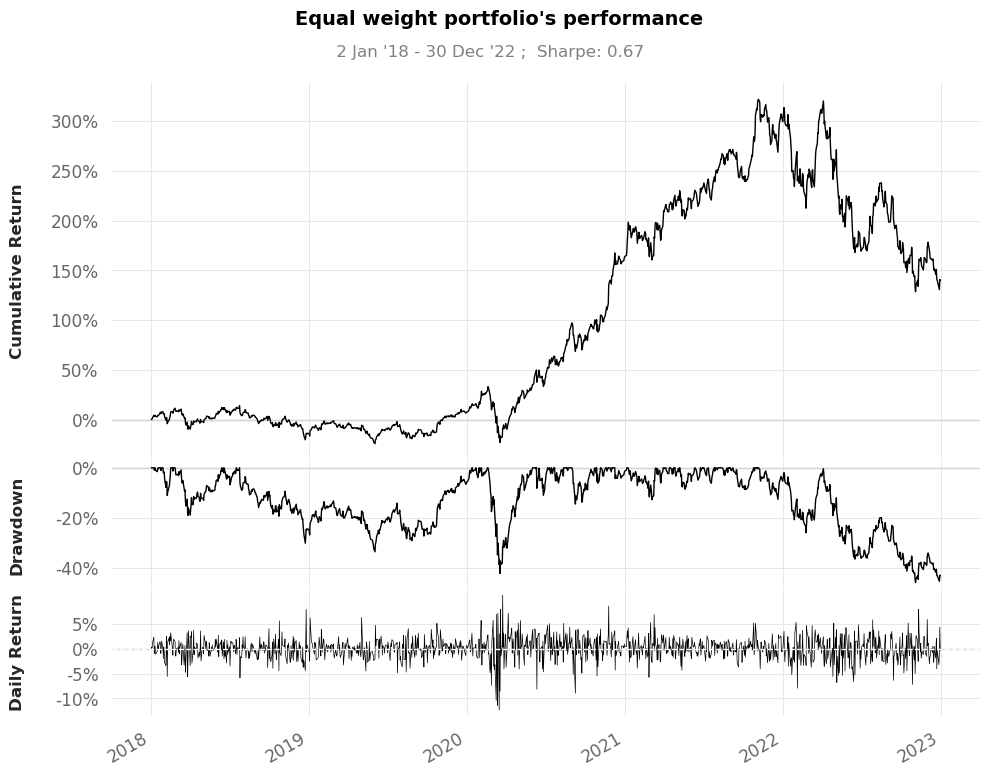

In [2]:
import logging
logging.getLogger('matplotlib.font_manager').setLevel(level=logging.CRITICAL)

# plot the portfolio performance
qs.plots.snapshot(portfolio_returns,title="Equal weight portfolio's performance",
grayscale=True)

plt.show()

A drawdown refers to the peak-to-trough decline in the value of an investment or a trading account, typically expressed as a percentage. It represents the largest loss an investor or fund experiences before a new peak is reached. 

In [3]:
# get the metric for the portfolio using bechmark SPY which follows S&P500
# for more detailed discussion on the metric, please refer to Portfolio_analysis.ipynb

qs.reports.metrics(portfolio_returns,benchmark="SPY",mode="basic",prepare_returns=False)


[*********************100%%**********************]  1 of 1 completed
                    Benchmark (SPY)    Strategy
------------------  -----------------  ----------
Start Period        2018-01-03         2018-01-03
End Period          2022-12-30         2022-12-30
Risk-Free Rate      0.0%               0.0%
Time in Market      100.0%             100.0%

Cumulative Return   41.39%             139.13%
CAGR﹪              4.91%              12.82%

Sharpe              0.43               0.66
Prob. Sharpe Ratio  82.94%             93.0%
Sortino             0.59               0.94
Sortino/√2          0.42               0.67
Omega               1.12               1.12

Max Drawdown        -34.1%             -45.84%
Longest DD Days     361                534

Gain/Pain Ratio     0.09               0.12
Gain/Pain (1M)      0.43               0.63

Payoff Ratio        0.89               0.92
Profit Factor       1.09               1.12
Common Sense Ratio  0.92               1.12
CPC Index      

In [4]:
# save all the portfolio performance to html
qs.reports.html(portfolio_returns, 
benchmark="SPY", 
title="1/n portfolio",
download_filename="Portfolio_eval.html")

[*********************100%%**********************]  1 of 1 completed


Portfolio variance is defined as:

$\sigma_{port}^2 = weights^{T} \cdot Cov_{port} \cdot weights$

where $Cov_{port}$ is the covariance matrix of the portfolio and $weights$ is the vector of weights for each asset. 

In [5]:
# variance matrix 
var_yr = returns.cov() * 252

print(var_yr.shape,weights.T.shape,np.transpose(weights).shape)
# portfolio variance
port_var = weights.T@var_yr@weights

# portfolio volatility
port_vol = np.sqrt(port_var)

print(port_var, port_vol)

(4, 4) (4,) (4,)
0.13078862215604545 0.36164709615320495


In Modern Portfolio Theory (MPT), the goal is typically to either maximize the expected portfolio return for a given level of risk or minimize the portfolio risk for a given level of expected return. The optimization problem involves finding the weights of each asset in the portfolio that achieve these objectives. Here are the general formulas for the optimization problems in MPT:

<u>Maximizing Expected Portfolio Return for a Given Level of Risk</u>:

Objective:
$ \text{Maximize} \quad \text{Expected Portfolio Return} = \sum_{i=1}^{n} w_i \cdot \text{Expected Return}_i $

Subject to:
$ \sum_{i=1}^{n} w_i = 1 $
$ \text{Portfolio Variance} = \sum_{i=1}^{n} \sum_{j=1}^{n} w_i \cdot w_j \cdot \text{Covariance}_{ij} \leq \text{Target Risk} $

Where:
- $ n $ is the number of assets in the portfolio.
- $ w_i $ is the weight of asset $ i $ in the portfolio.
- $ \text{Expected Return}_i $ is the expected return of asset $ i $.
- $ \text{Covariance}_{ij} $ is the covariance between the returns of assets $ i $ and $ j $.
- The constraint $ \sum_{i=1}^{n} w_i = 1 $ ensures that the weights sum up to 1.

<u>Minimizing Portfolio Risk for a Given Level of Expected Return</u>:

Objective:
$ \text{Minimize} \quad \text{Portfolio Variance} = \sum_{i=1}^{n} \sum_{j=1}^{n} w_i \cdot w_j \cdot \text{Covariance}_{ij} $

Subject to:
$ \sum_{i=1}^{n} w_i \cdot \text{Expected Return}_i \geq \text{Target Expected Return} $
$ \sum_{i=1}^{n} w_i = 1 $

Where:
- $ \text{Target Expected Return} $ is the desired level of expected return for the portfolio.

These optimization problems are typically solved using mathematical optimization techniques. The solutions will give you the set of portfolio weights that achieve the specified objectives.

## Efficient Frontier Using Monte Carlo

The efficient frontier is a set of optimal portfolios in the 
risk-return spectrum.

In [6]:
# Efficient frontier
import pandas as pd 

def portfolio_annualized_performance(weights, mean_returns, cov_matrix):
    # Calculate the annulaized portfolio return
    returns = np.dot(mean_returns, weights) * 252

    # Calculate the annulaized portfolio volatility
    stdv = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    return stdv, returns


def random_port_gen(nsim, expected_returns, covariance_matrix, risk_free_rate):
    # Initialize array to store results, where each column represents a portfolio
    p_results = np.zeros((3, nsim))
    # List to store the weights of each equity in each portfolio
    p_weights = []

    for i in range(nsim):
        # Generate random weights for each equity
        weights = np.random.random(len(expected_returns))
        # Normalize the weights to sum to 1
        weights /= np.sum(weights)
        # Add the weights to the portfolio weight list
        p_weights.append(weights)

        # Calculate portfolio standard deviation and return
        p_std_dev, p_return = portfolio_annualized_performance(weights, expected_returns, covariance_matrix)

        # Store the results
        p_results[0, i] = p_std_dev
        p_results[1, i] = p_return

        # Calculate and store the Sharpe ratio
        p_results[2, i] = (p_return - risk_free_rate) / p_std_dev

    result_df = pd.DataFrame(p_results.T, columns=['std_dev', 'return', 'sharpe'])

    return result_df, p_weights


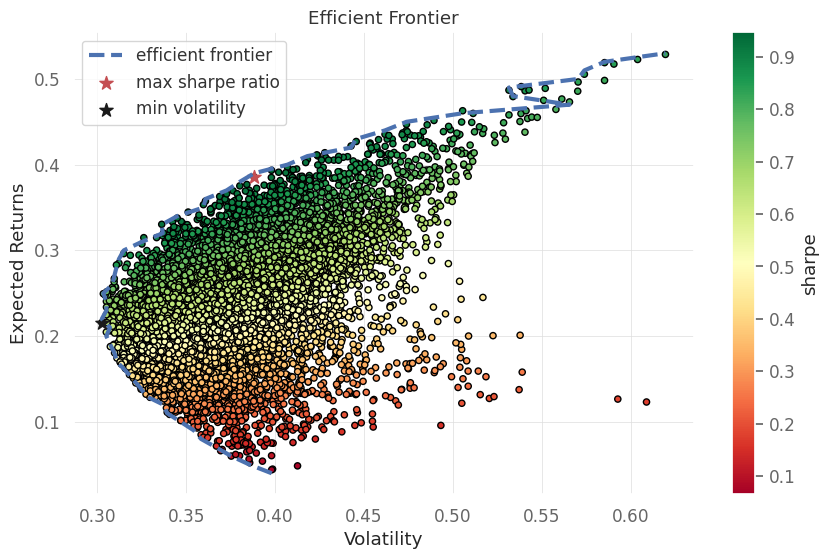

In [76]:

mean_returns = returns.mean()
cov_matrix = returns.cov()
# Number of portfolios to simulate
nsim = 10000
# Risk free rate 
risk_free_rate = 0.018

# run the simulation
results, weights = random_port_gen(nsim,mean_returns, cov_matrix, risk_free_rate)

# get max Sharpe ratio index
max_sharpe_idx = np.argmax(results['sharpe'].values)

# get minimum volatility
min_vol_idx = np.argmin(results['std_dev'].values)

# get std_dev and returns at max Sharpe ratio
stdev_maxsharpe, returns_maxsharpe = results['std_dev'].iloc[max_sharpe_idx], results['return'].iloc[max_sharpe_idx]


# get std_dev and returns at minimum volatility
stdev_minvol, returns_minvol = results['std_dev'].iloc[min_vol_idx], results['return'].iloc[min_vol_idx]


# pull the allocation associated with max Sharpe ratio
max_sharpe_allocation =  pd.DataFrame(weights[max_sharpe_idx],index=prices_df.columns,columns=['allocation'])
# round off
max_sharpe_allocation['allocation'] = [round(i*100,2) for i in max_sharpe_allocation['allocation']]


# pull the allocation associated with max Sharpe ratio
min_vol_allocation = pd.DataFrame(weights[min_vol_idx],index=prices_df.columns,columns=['allocation'])
# round off
min_vol_allocation['allocation'] = [round(i*100,2) for i in min_vol_allocation['allocation']]




ef_rtn_list = []
ef_vol_list = []

# get range of possible returns
possible_ef_rtns = np.linspace(0.02, 0.55, 100)
possible_ef_rtns = np.round(possible_ef_rtns, 2) 

# get returns
portf_rtns = np.round(results["return"].values, 2)


for rtn in possible_ef_rtns:
    if rtn in portf_rtns:
        ef_rtn_list.append(rtn)
        # get index of matching return
        matched_ind = np.where(portf_rtns == rtn)
        # choose mimum volatility for each possible return
        ef_vol_list.append(np.min(results["std_dev"].iloc[matched_ind]))

#Group by 'Bin' and calculate the minimum value for 'Values' in each bin


# Define bin edges
bin_edges = np.linspace(0.02, 0.55, 50)

# Create a new column 'Bin' based on the bin edges
results['Bin'] = pd.cut(results['return'], bins=bin_edges)


min_values = results.groupby('Bin')['std_dev'].min().reset_index()

min_values['Bin_Midpoint'] = min_values['Bin'].apply(lambda x: x.mid)


fig, ax = plt.subplots()
results.plot(kind="scatter", x="std_dev",
            y="return", c="sharpe",
            cmap="RdYlGn", edgecolors="black",
            ax=ax)

ax.set(xlabel="Volatility",
ylabel="Expected Returns",
title="Efficient Frontier")
ax.plot(ef_vol_list, ef_rtn_list,"b--",linewidth=3,label="efficient frontier")

# Plot the binned data
# ax.plot(min_values['std_dev'], min_values['Bin_Midpoint'], color='blue', linestyle='-', linewidth=2,alpha=0.4,label='efficient frontier')

# plot max Sharpe ratio
ax.scatter(stdev_maxsharpe, returns_maxsharpe, marker='*', color='r', s=100,label='max sharpe ratio')

# plot min volatility
ax.scatter(stdev_minvol, returns_minvol, marker='*', color='k', s=100,label='min volatility')

# ax.set_xlabel(r'Risk')
# ax.set_ylabel(r'Return')
# ax.plot()

# cbar = fig.colorbar(cb)
# cbar.set_label('Sharpe Ratio')


ax.legend()
plt.show()

# plt.show()

In [14]:
print("At maximum Sharpe Ratio\n")
print(f"Return:{returns_maxsharpe}")
print(f"Volatility: {stdev_maxsharpe}")
print(f"Portfolio: {max_sharpe_allocation}")
print("\n")
print("At Minimum risk\n")
print(f"Return:{returns_minvol}")
print(f"Volatility: {stdev_minvol}")
print(f"Portfolio: {min_vol_allocation}")
print("\n")

At maximum Sharpe Ratio

Return:0.37844653371199477
Volatility: 0.3797104952470299
Portfolio:       allocation
META        0.91
MSFT       60.59
TSLA       38.42
X           0.09


At Minimum risk

Return:0.21651013176568432
Volatility: 0.3025809252516971
Portfolio:       allocation
META       13.60
MSFT       74.95
TSLA        0.38
X          11.07




### Efficient frontier using Scipy

In order to find the portfolio that gives highest returns for a given risk (volatility) or lowest risk (volatility) for a given return we can utilise numerical optimization. Optimization gives the best value of a function subjected to some boundary contraints affecting the target variable.

In the case of porfolio optimization we can express the equations as:

$ min (\omega^T \Sigma \omega)$

with constraints:

\begin{align*}
\omega^T \bold{I}=& b\\
\omega \geq& 0\\
\omega^{T}\mu =& \mu_p
\end{align*}

here $\omega$ is the weight vector, $\Sigma$ is the covariance matrix, $\mu$ is the vector of returns with $\mu_p$ is the expected portfolio return.

For a range of expected returns we find the optimal weights


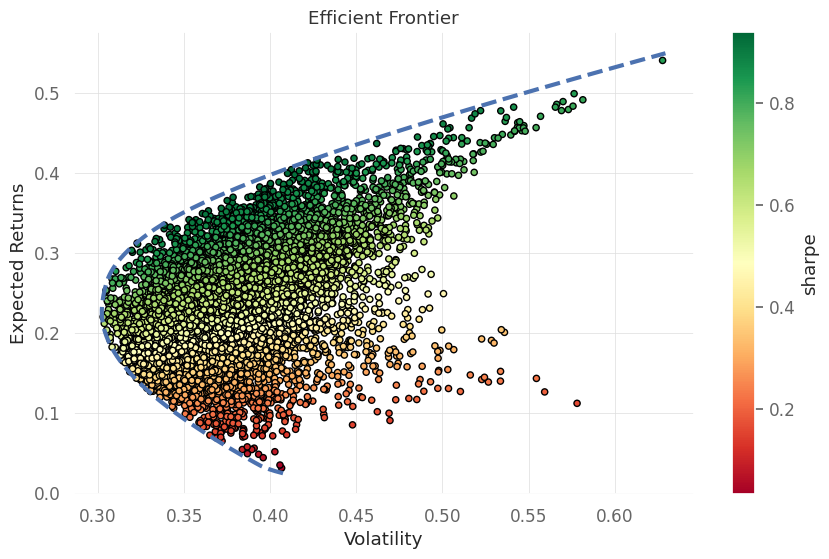

In [36]:
import numpy as np
import scipy.optimize as sco

# function to calculate portfolio return.
def portfolio_return(weights, asset_returns):
    return np.dot(weights, asset_returns)

# function to calculate portfolio volatility.
def portfolio_volatility(weights, covariance_matrix):
    return np.sqrt(np.dot(weights.T, np.dot(covariance_matrix, weights)))

# function to efficient portfolios along the efficient frontier.
def Efficient_frontier(asset_returns, covariance_matrix, target_returns):
    """
    Parameters:
    - asset_returns (array): Array of average returns for each asset.
    - covariance_matrix (array): Covariance matrix of asset returns.
    - target_returns (array): Array of target returns for which efficient portfolios are generated.
    """
    efficient_portfolios = []

    # Number of assets
    n_assets = len(asset_returns)

    # Define bounds for weights (between 0 and 1)
    bounds = tuple((0, 1) for _ in range(n_assets))

    # Initial guess for weights (equally weighted)
    weights0 = n_assets * [1. / n_assets, ]

    # Loop through target returns and find corresponding efficient portfolios
    for target_return in target_returns:
        # Constraints for optimization
        constraints = (
            {"type": "eq", "fun": lambda weights: portfolio_return(weights, asset_returns) - target_return},
            {"type": "eq", "fun": lambda weights: np.sum(weights) - 1}
        )

        # Optimize for minimum volatility
        result = sco.minimize(
            portfolio_volatility,
            weights0,
            args=(covariance_matrix,),
            method="SLSQP",
            constraints=constraints,
            bounds=bounds
        )

        # Save information about the efficient portfolio
        efficient_portfolios.append({
            'Return': target_return,
            'Volatility': result.fun,
            'Weights': result.x.tolist()
        })

    return efficient_portfolios


# define returns range
returns_range = np.linspace(0.025, 0.55, 400)

# covariance matrix
covariance_matrix = returns.cov() * 252

# asset returns
asset_returns = returns.mean() * 252

# run efficient frontier optimization
efficient_portfolios = Efficient_frontier(asset_returns, covariance_matrix, returns_range)

# volatility range
volatility_range = [p['Volatility'] for p in efficient_portfolios]


# plot efficient frontier

fig, ax = plt.subplots()

results.plot(kind="scatter", x="std_dev",y="return", c="sharpe",cmap="RdYlGn", edgecolors="black",ax=ax)

ax.plot(volatility_range, returns_range, "b--", linewidth=3)
ax.set(xlabel="Volatility",ylabel="Expected Returns",title="Efficient Frontier")
plt.show()
